In [165]:
import logging, gensim
from gensim import corpora, models, similarities,matutils
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn.datasets
import nltk
import numpy as np
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

In [148]:
# Load Data
corpus = corpora.MmCorpus('20newsgroup.mm')
dictionary = corpora.Dictionary.load('20newsgroup.dict')

In [134]:
# ap.dat - Each document is one line with - N fieldId1:fieldValue1 fieldId2:fieldValue2 ... fieldIdN:fieldValueN
# The vocabulary is a file with words, one word per line; word at line K has an implicit id=K.
corpus = corpora.BleiCorpus('ap.dat','vocab.txt')

In [3]:
# Smaller alpha will result in fewer topics for each document
model = models.ldamodel.LdaModel(corpus,num_topics=100,id2word=corpus.id2word,alpha=1)

In [136]:
print(corpus)
# doc = corpus.docbyoffset(0)
# topics = model[doc]
# print(topics)

In [5]:
num_topics_used = [len(model[doc]) for doc in corpus]

(array([  56.,   89.,  224.,  424.,  764.,  484.,  144.,   44.,   11.,    6.]),
 array([  1. ,   5.7,  10.4,  15.1,  19.8,  24.5,  29.2,  33.9,  38.6,
         43.3,  48. ]),
 <a list of 10 Patch objects>)

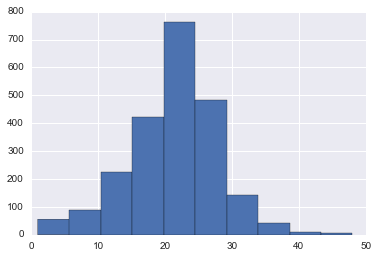

In [6]:
plt.hist(num_topics_used)

In [11]:
#train = sklearn.datasets.fetch_20newsgroups(subset='train',remove=('headers'))
train = sklearn.datasets.fetch_20newsgroups(subset='train')
test = sklearn.datasets.fetch_20newsgroups(subset='test')

In [13]:
#train.target_names
#train.filenames
#train.target[:10]
documents = train.data[:10]

In [59]:
s = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        #StemmedCountVectorizer will return CountVectorizer build_analyzer code
        analyzer = super(TfidfVectorizer,self).build_analyzer()
        return lambda doc: (s.stem(w) for w in analyzer(doc))

# default min_df = 1, max_df = 1.0
# In other words, tf-idf weight in document that is
# highest when the terms occurs many times within a small number of documents (thus lending high discriminating power to those documents);
# lower when the term occurs fewer times in a document, or occurs in many documents (thus offering a less pronounced relevance signal);
# lowest when the term occurs in virtually all documents.
vectorizer = StemmedTfidfVectorizer(min_df=1,stop_words='english',decode_error='ignore')

In [112]:
vectorized = vectorizer.fit_transform(documents)
features = np.array(vectorizer.get_feature_names())
# type(features)
texts = [list(features[list((vectorized>0)[i].nonzero()[1])]) for i,doc in enumerate(documents)]

In [127]:
# dictionary = corpora.Dictionary(line.lower().split() for line in open('mycorpus.txt'))
# Maps a word to a ID
dictionary = corpora.Dictionary(texts)
dictionary.save('20newsgroup.dict') # store the dictionary, for future reference
print(dictionary)
print(dictionary.token2id)

Dictionary(675 unique tokens: ['late', '1r1eu1', 'car', 'post', 'messag']...)
{'late': 0, '1r1eu1': 440, 'car': 2, 'post': 3, 'messag': 54, 'error': 299, 'special': 414, 'attain': 55, 'show': 501, 'spec': 6, 'address': 227, 'ghost': 116, 'cruce': 503, 'wonder': 38, 'slower': 523, 'uni': 611, 'unless': 618, '1991': 500, 'powerbook': 166, '800': 63, 'n33': 516, 'memori': 288, 'reword': 377, 'compani': 400, 'don': 136, 'hole': 643, 'glad': 473, 'jgreen': 236, 'alleg': 366, 'appear': 124, 'modern': 358, 'treatment': 483, 'stuff': 240, '60s': 20, 'bunch': 126, 'bounc': 487, 'washington': 91, '1985': 132, 'agre': 361, 'curious': 300, 'believ': 362, 'instead': 493, '12': 495, 'phone': 242, 'crimial': 389, 'stac': 660, 'inform': 248, 'scare': 250, 'hellcat': 139, 'make': 140, 'edu': 32, 'repli': 477, 'say': 398, 'machin': 142, 'wrong': 647, 'goe': 230, 'clear': 325, 'iowa': 606, 'lie': 145, 'ux1': 668, 'respond': 476, '10mb': 535, 'lawrenc': 381, 'dxb132': 537, 'diskdoubl': 672, 'histori': 43,

In [86]:
# x = np.array([[1,2],[2,4]])
# print("x ",x.shape)
# y = np.array([[1,2],[2,4]])
# print("x ",y.shape)

x  (2, 2)


In [147]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('20newsgroup.mm', corpus) # store to disk, for later use
mm = corpora.MmCorpus('20newsgroup.mm')
# Word ID , Frequency for each document
print(mm)

MmCorpus(10 documents, 675 features, 870 non-zero entries)


In [156]:
tfidf = models.TfidfModel(corpus) # Initialize Tfidf
corpus_tfidf = tfidf[corpus] # Transform Test Corpus

# lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) # initialize an LSI transformation
# corpus_lsi = lsi[corpus_tfidf] # create a double wrapper over the original corpus: corpus->tfidf->fold-in-lsi

lda_model = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=100)
# model = hdpmodel.HdpModel(bow_corpus, id2word=dictionary)

In [158]:
topics = lda_model[corpus_tfidf]

In [163]:
for t in topics:
    print(features[(t[0][0])])

60s
1qlbrlinn7rk
60s
20mb
20mb
734340159
bear
activ
anybodi
40mb


(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 <a list of 10 Patch objects>)

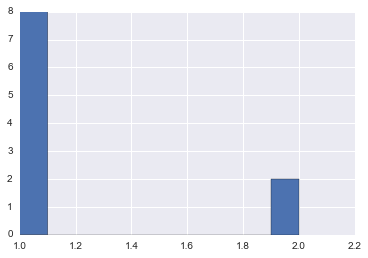

In [164]:
num_topics = [len(lda_model[doc]) for doc in corpus_tfidf]
plt.hist(num_topics)